Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы.

Стоимость туров:

- Таиланд — 100000 рублей;
- Турция — 60000 рублей;
- Мальдивы — 200000 рублей;
- Санкт-Петербург — 10000 рублей;
- Камчатка — 150000 рублей.

Проверьте, какая из страниц приносит больше покупок.

ЗАДАЧИ
1. Провести первичный анализ датасета. В рамках этой задачи вам предстоит:

- привести столбцы к корректным типам данных;
- убедиться, что данные по обеим группам представлены за одинаковый период (визуализировать);
- проверить корректность распределения участников теста;
- проверить различие в группах;
- проверить пересечение аудитории в группах;
- определить по группам ряд показателей (количество пользователей, количество покупок, выручку, конверсию, средний чек);
- посмотреть, как распределяются суммы покупок (здесь необходимо повизуализировать);
- сделать первичные выводы.
2. Рассчитайте кумулятивные метрики:
- постройте график конверсии в группах по дням;
- постройте график среднего чека в группах по дням;
- постройте график кумулятивных метрик по конверсии и по среднему чеку;
- сделайте выводы.
3. Проведите статистическую проверку гипотез:
- о равенстве конверсии;
- о равенстве выручки;
- о равенстве средних чеков по дням.
4. Сделайте вывод.

In [90]:
import pandas as pd
import scipy.stats as st 

In [91]:
df = pd.read_csv('ab_data.csv')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  294478 non-null  int64 
 1   user_id     294478 non-null  int64 
 2   date        294478 non-null  object
 3   group       294478 non-null  object
 4   purchase    294478 non-null  int64 
 5   price       294478 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.5+ MB


Приводим столбец "date" к типу "datetime64[ns]"

In [93]:
df['date'] = pd.to_datetime(df['date'])

In [94]:
df.head()

,Unnamed: 0,user_id,date,group,purchase,price
0,0,851104,2021-01-21,A,0,0
1,1,804228,2021-01-12,A,0,0
2,2,661590,2021-01-11,B,0,0
3,3,853541,2021-01-08,B,0,0
4,4,864975,2021-01-21,A,1,150000


In [95]:
df['date'].describe()

C:\Users\Lubchanskiy\AppData\Local\Temp\ipykernel_35960\801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                  294478
unique                     23
top       2021-01-08 00:00:00
freq                    13564
first     2021-01-02 00:00:00
last      2021-01-24 00:00:00
Name: date, dtype: object

In [96]:
df.groupby('group').agg({'user_id': 'count'})

,user_id
group,
A,147202
B,147276


Находим пользавателей которые находятся в обоих группах

In [100]:
df_del = df.groupby(['user_id']).agg({'group': 'nunique'}).reset_index()

больше 1 группы на пользователе

In [102]:
df_del = df_del[df_del['group']>1]

In [103]:
df_del

,user_id,group
281,630320,2
726,630805,2
787,630871,2
802,630887,2
911,631008,2
...,...,...
289917,945272,2
289952,945308,2
290010,945369,2
290025,945387,2


In [106]:
delete_list = df_del['user_id'].unique()

Столько дубликатов

In [107]:
len(delete_list)

1895

Удаляем их

In [108]:
df_clear = df[~(df['user_id'].isin(delete_list))]

Пользователей после исключения

In [118]:
df_clear.groupby('group').agg({'user_id': 'count'}).reset_index()

,group,user_id
0,A,145307
1,B,145381


In [120]:
1 - (df_clear.groupby('group').agg({'user_id': 'count'}).reset_index()['user_id'][0] / df_clear.groupby('group').agg({'user_id': 'count'}).reset_index()['user_id'][1])

0.0005090073668498896

разница 0,051%, что меньше 1% - продолжаем

In [121]:
df_clear.columns

Index(['Unnamed: 0', 'user_id', 'date', 'group', 'purchase', 'price'], dtype='object')

Собираем показатели конверсии и среднего чека по каждой группе


In [123]:
df_groups = df_clear.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()

Добавляем конверсию и средний чек по группам

In [125]:
df_groups['conversion'] = df_groups['purchase'] / df_groups['user_id']
df_groups['avg_check'] = df_groups['price'] / df_groups['purchase']


In [126]:
df_groups

,group,user_id,purchase,price,conversion,avg_check
0,A,145307,17487,1417780000,0.120345,81076.228055
1,B,145381,17290,1533010000,0.118929,88664.545980


In [129]:
import matplotlib.pyplot as plt

In [130]:
df_a = df_clear[df_clear['group']=='A']
df_b = df_clear[df_clear['group']=='B']

ValueError: `bins` must increase monotonically, when an array

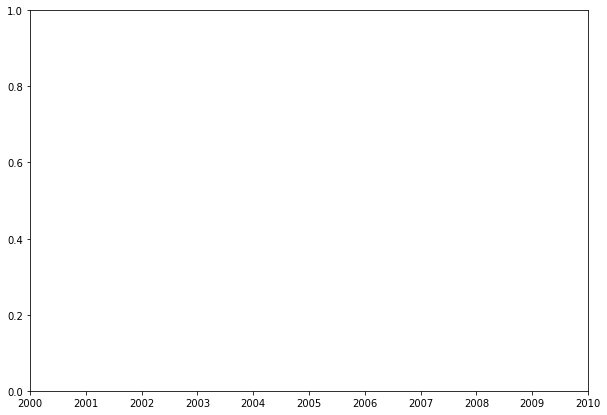

In [132]:
plt.figure(figsize=(10,7))
plt.hist(df_a['date'], df_a['purchase'], label='Group A')
plt.hist(df_b['date'], df_b['purchase'], label='Group B')
plt.title('График покупок по группам')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()